# Test Local GPU

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_absolute_error

import os
import random
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
seed_value = 10
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

# check whether GPU is available for tensorflow
print(tf.test.is_built_with_cuda())
print(device_lib.list_local_devices())

True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11869803027903071743
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1393599692
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15061923839992963534
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


### Make sure you have physical GPU

* If there is no output below, need to uninstall `tensorflow` and just keep installed `tensorflow-gpu`
  * `pip unistall tensorflow`
  * `pip install --upgrade tensorflow-gpu`

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


## How to Toggle between CPU and GPU

In [5]:
device_names = [x.name for x in device_lib.list_local_devices()]

for device_name in device_names:
    if device_name == "/device:GPU:0":
        device_name = "/gpu:0"
    else:
        device_name = "/cpu:0"

    with tf.device(device_name):
        print(device_name)
        a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
        b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
        c = tf.matmul(a, b)
        print(device_name, c)
        print()

/cpu:0
/cpu:0 tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)

/gpu:0
/gpu:0 tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)



## GPU vs CPU

### Data Preprocessing

* Data is downloaded from https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [3]:
df = pd.read_csv('../time_series/data/pm25.csv')

print(df.shape)
df.head()

(43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
df.dropna(subset=['pm2.5'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(
    lambda row: datetime.datetime(year=row['year'], 
                                  month=row['month'], day=row['day'],hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_pm2.5'] = scaler.fit_transform(np.array(df['pm2.5']).reshape(-1, 1))

split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)  
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
df_val.reset_index(drop=True, inplace=True)
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (33096, 15)
Shape of test: (8661, 15)


In [5]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
        
    X, y = np.array(X), np.array(y)
    return X, y

In [6]:
X_train, y_train = makeXy(df_train['scaled_pm2.5'], 7)
X_val, y_val = makeXy(df_val['scaled_pm2.5'], 7)

print('Shape of train arrays:', X_train.shape, y_train.shape)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of arrays after reshaping:', X_train.shape, X_val.shape)

Shape of train arrays: (33089, 7) (33089,)
Shape of validation arrays: (8654, 7) (8654,)
Shape of arrays after reshaping: (33089, 7, 1) (8654, 7, 1)


### Common Functions

In [16]:
# def stack_models(X_train, device_name):
#     model = Sequential()
#     if device_name == '/cpu:0':
#         model.add(LSTM(32,
#                        dropout=0.2,
#                        recurrent_dropout=0.5,
#                        return_sequences=True,
#                        input_shape=(X_train.shape[1:])))
#         model.add(LSTM(32, 
#                        activation='tanh',
#                        dropout=0.2, 
#                        recurrent_dropout=0.5))
#         model.add(Dense(1, activation='tanh'))
#     else:
#         model.add(CuDNNLSTM(32,
#                        return_sequences=True,
#                        input_shape=(X_train.shape[1:])))
#         model.add(CuDNNLSTM(32, return_sequences=True))
#         model.add(Dense(1, activation='tanh'))

#     model.compile(optimizer=Adam(amsgrad=True, learning_rate=0.1), loss='mean_absolute_error', metrics='mae')
#     model.summary()
#     return model

def stack_models(X_train, device_name):
    model = Sequential()
    model.add(LSTM(32,
                    dropout=0.2,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(X_train.shape[1:])))
    model.add(LSTM(32, 
                    activation='tanh',
                    dropout=0.2, 
                    recurrent_dropout=0.5))
    model.add(Dense(1, activation='tanh'))

    model.compile(optimizer=Adam(amsgrad=True, learning_rate=0.1), loss='mean_absolute_error', metrics='mae')
    model.summary()
    return model

def fit_diy_model(model, X_train, y_train, X_val, y_val, model_name):
    start_time = time.time()
    save_weights_at = model_name
    save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                                save_best_only=True, save_weights_only=False, mode='min',
                                save_freq='epoch')
    history = model.fit(x=X_train, y=y_train, batch_size=100, epochs=20,
                 verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
                 shuffle=True)
    print("--- %s seconds ---" % (time.time() - start_time))
    return history

def evaluate_diy_model(model_name, history, X_val, df_val):
    # load the best model
    best_model = load_model(model_name)

    # Compare the prediction with y_true
    preds = best_model.predict(X_val)
    pred_pm25 = scaler.inverse_transform(preds)
    pred_pm25 = np.squeeze(pred_pm25)

    # Measure MAE of y_pred and y_true
    mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
    print('MAE for the validation set:', round(mae, 4))

    mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
    print('MAE for the scaled validation set:', round(mae, 4))

    # Check the metrics and loss of each apoch
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    plt.plot(epochs, mae, 'bo', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.legend()

    plt.figure()

    # Here I was using MAE as loss too, that's why they lookedalmost the same...
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

### CPU

* Note: the warning below doesn't mean you are using GPU. In fact it's using CPU here since I'm tracking the Windows Task Manager's "Performance".
* To track whether there is really GPU in use, need to make sure `tf.config.experimental.list_physical_devices('GPU')` has at least 1 GPU available.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 7, 32)             4352      
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
331/331 [==============================] - 7s 11ms/step - loss: 0.0721 - mae: 0.0721 - val_loss: 0.0210 - val_mae: 0.0210
INFO:tensorflow:Assets written to: stacking_lstm_model_tanh_cpu\assets
Epoch 2/20
331/331 [==============================] - 3s 10ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0191 - val_mae: 0.0191
INFO:tensorflow:Assets written to: stacking

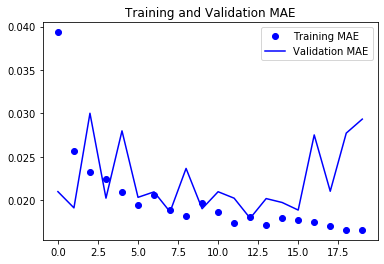

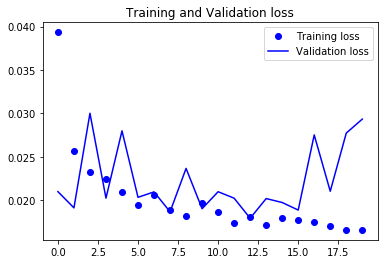

In [19]:
# Stacked LSTMs
device_name = '/cpu:0'
with tf.device(device_name):
    model_name = 'stacking_lstm_model_tanh_cpu'
    model = stack_models(X_train, device_name)
    history = fit_diy_model(model, X_train, y_train, X_val, y_val, model_name)
    evaluate_diy_model(model_name, history, X_val, df_val)

### GPU

* The GPU utilization for this example is very small (less than 10% utilization) even after I have increased the batch size from 16 to 3000
  * People suggest to increase the batch size when GPU utilization is low....
* <b>GPU does't always work better than CPU.</b> As you can see from the the results below, CPU is much faster than GPU.
  * Because the overhead of invoking GPU kernels, and copying data to and from GPU, is very high. For operations on models with very little parameters it is not worth of using GPU
  * I was tracking Windows "Task Manage", when it's using GPU, the utilization of CPU is higher than GPU utilization, might be caused by GPU related operations. (When it's using CPU, the utilization of CPU is much higher, 0% utilization of GPU)
  * I have also tried `CuDNNLSTM` to replace lstm for GPU, since it's faster, but it's still underdeveopped
    * "dropout" and "activation" are not supported in `CuDNNLSTM` for now....😔😔
    * Somehow it's compalining the data didn't have initial state. I'm wondering whether it's because my current CUDA server is the latest (released on Dec. 2020) but the matched cuDNN hasn't come out... (released on Nov. 2020)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 32)             4352      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
331/331 [==============================] - 101s 280ms/step - loss: 0.0788 - mae: 0.0788 - val_loss: 0.0241 - val_mae: 0.0241
INFO:tensorflow:Assets written to: stacking_lstm_model_tanh_gpu\assets
Epoch 2/20
331/331 [==============================] - 67s 204ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0235 - val_mae: 0.0235
INFO:tensorflow:Assets written to: sta

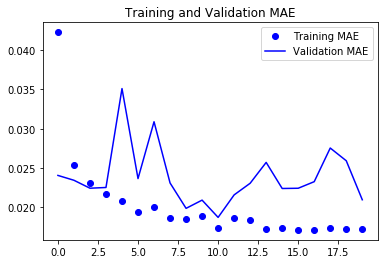

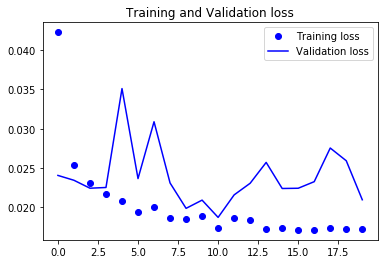

In [17]:
# Stacked LSTMs
device_name = '/gpu:0'
with tf.device(device_name):
    model_name = 'stacking_lstm_model_tanh_gpu'
    model = stack_models(X_train, device_name)
    history = fit_diy_model(model, X_train, y_train, X_val, y_val, model_name)
    evaluate_diy_model(model_name, history, X_val, df_val)